In [1]:
import matplotlib.pyplot as plt
import tools.dataTools as dt
from constants import Constants
import figure_params
import os
import pickle
from textwrap import wrap
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import pyaldata as pyal
from scipy.linalg import orth, null_space
from sklearn.linear_model import LinearRegression
figure_params.set_rc_params()
figure_params.setup_directories()

SUBFIG_DIR = Constants.FIG_FOLDER + 'figS2_reach_angle/'
if not os.path.exists(SUBFIG_DIR):
    os.makedirs(SUBFIG_DIR)

#run simulations for figure
import subprocess
subprocess.call(['sh', '../simulation/fig_simulations/fig2_sims.sh'])


In [2]:
repertoires = Constants.UNIS
reps = repertoires
seed_ex = Constants.SEED_EX
sim_set = 'uni_rad'
seeds = Constants.SEEDS

In [3]:
sim_set = 'uni_rad'
datafile = 'uni_10.0_rad'
redo = False

fname = Constants.PROCESSED_DATA_FOLDER + sim_set + '/'+ 'repertoire_comparison_measures_norm.pickle'
if os.path.isfile(fname) & (not redo):
    with open(fname, 'rb') as f:
        measures_df = pickle.load(f)
else:
    #calculate variance for unit activity, latent activity, position, and angle
    rows_list = []
    for seed in tqdm(seeds):
        for repertoire in repertoires:
            #get simulation data
            exec_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.exec_epoch, 
                subtract_mean=False, datafile = datafile, calculate_kinematics=True)
            exec_df = dt.perform_pca(exec_df, Constants.PCA_DIMS)
            prep_exec_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.prep_exec_epoch, 
                subtract_mean=False, datafile = datafile)
            prep_exec_df = dt.perform_pca(prep_exec_df, Constants.PCA_DIMS)
            exec_df_noise = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.exec_epoch, 
                subtract_mean=False, datafile = datafile, noise=1.0)

            #calculate variance #############
            var_rates = np.var(prep_exec_df.MCx_rates.values, axis = 0).flatten()
            var_pca = np.var(prep_exec_df.both_pca.values, axis = 0).flatten()
            var_pos = np.var(exec_df.pos.values, axis = 0).flatten()

            # output null/potent variance
            Y = pyal.concat_trials(prep_exec_df,'pos').T
            # calculate variance in output-null/potent spaces
            subspace_var = {}
            for signal in ['MCx_rates', 'both_pca']:
                centered_df = pyal.center_signal(prep_exec_df,signal)
                X = pyal.concat_trials(centered_df,signal).T
                lr = LinearRegression().fit(X.T, Y.T)
                W_potent = orth(lr.coef_.T)
                W_null = null_space(lr.coef_)

                subspace_var['var_exp_potent_'+signal] = dt.variance_in_subspace(X.T,W_potent)
                subspace_var['var_exp_null_'+signal] = dt.variance_in_subspace(X.T,W_null)

                # Y_calc_lr = ((lr.coef_ @ X).T + lr.intercept_).T
                prep_exec_df['null_'+signal] = [s @ W_null for s in centered_df[signal]]
                prep_exec_df['potent_'+signal] = [s @ W_potent for s in centered_df[signal]]
                
            var_rates_null = np.var(prep_exec_df.null_MCx_rates.values, axis = 0).flatten()
            var_rates_potent = np.var(prep_exec_df.potent_MCx_rates.values, axis = 0).flatten()
            var_pca_null = np.var(prep_exec_df.null_both_pca.values, axis = 0).flatten()
            var_pca_potent = np.var(prep_exec_df.potent_both_pca.values, axis = 0).flatten()

            # angular reach
            mean_vel = np.array([np.mean(vel,axis = 0) for vel in exec_df.vel])
            reach_angles = np.degrees(np.arctan2(mean_vel[:,1], mean_vel[:,0]))
            var_angles = np.var(reach_angles) 

            #calculate x velocity
            xvels = (np.diff(np.array(exec_df_noise.pos.tolist())[:,:,0], axis =1)/Constants.BIN_SIZE).flatten()

            temp = {
                'seed': seed,
                'repertoire': repertoire,
                'var_rates': var_rates,
                'var_rates_null': var_rates_null,
                'var_rates_potent': var_rates_potent,
                'var_exp_rates_null': subspace_var['var_exp_null_MCx_rates'],
                'var_exp_rates_potent': subspace_var['var_exp_potent_MCx_rates'],
                'var_pca': var_pca,
                'var_pos': var_pos,
                'var_angles': var_angles,
                # 'tangling_motor_noise': Q_pos_noise,
                # 'tangling_motor': Q_pos,
                'xvels': xvels,
            }
            temp['var_exp_rates_null_frac'] = temp['var_exp_rates_null']/(temp['var_exp_rates_null']+temp['var_exp_rates_potent'])
            temp['var_exp_rates_potent_frac'] = temp['var_exp_rates_potent']/(temp['var_exp_rates_null']+temp['var_exp_rates_potent'])
            temp['var_exp_pca_null_frac'] = temp
            
            rows_list.append(temp)

    measures_df = pd.DataFrame(rows_list)
    with open(fname, 'wb') as f:
        pickle.dump(measures_df, f)

0.0009765625
0.001953125
0.001953125


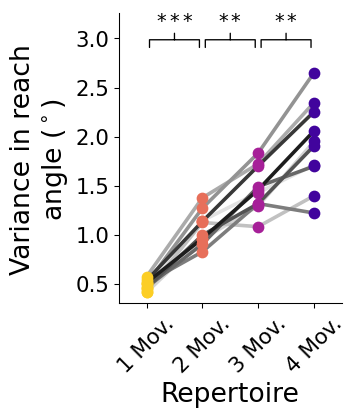

In [4]:
# reach_angle
# variance in unit activity
g = dt.compare_measure(measures_df, 'var_angles', reps, stats_alternative = 'less')
g.set_ylabel("\n".join(wrap('Variance in reach angle ($^\circ$)',17)))
plt.savefig(SUBFIG_DIR + 'var_angles_all.pdf', format = 'pdf', bbox_inches = 'tight')
